In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt
from pycbc import psd as psd_func
from pycbc.filter import overlap_cplx
from pycbc.types import TimeSeries
from pycbc.waveform import taper_timeseries
from pycbc.psd import aLIGOZeroDetHighPower
import astropy.constants as aconst
import scipy.constants as const
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from pesummary.gw.conversions.mass import component_masses_from_mtotal_q, eta_from_m1_m2
from simple_pe.waveforms import generate_eccentric_waveform, make_waveform, compute_s_factor, shifted_f, shifted_e

import logging
_logger = logging.getLogger('PESummary')
_logger.setLevel(logging.CRITICAL + 10)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal
/home/ben.patterson/.conda/envs/igwn_eccentric_new/lib/python3.10/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this p

lal.MSUN_SI != Msun


# Evolution equations

In [8]:
# Sets up evolution equation
def setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO):
    
    # Converts parameters
    m1, m2 = component_masses_from_mtotal_q(M, 1/q)
    nu = eta_from_m1_m2(m1, m2)
    x = (2*np.pi*const.G*M*0.5*f/const.c**3)**(2/3)
    chis = 0.5*(chi1+chi2)
    chia = 0.5*(chi1-chi2)
    delta = (m1-m2)/M

    # Which pn, SO terms to include
    if incl_lower_pn:
        pn_terms = np.arange(0, pn+0.5, 0.5)
    else:
        pn_terms = [pn]
    if incl_lower_SO:
        SO_terms = np.arange(0, SO+1, 1)
    else:
        SO_terms = [SO]

    return nu, x, chis, chia, delta, pn_terms, SO_terms

In [9]:
# Calculates da/dt up to 2pn and two orders in aligned spin
def da_dt_evol(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):

    # Setup evolution
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO)
    result = 0
    overall_prefactor = const.c*nu
    
    # 0 SO term
    if 0 in SO_terms:

        # 0 PN term
        if 0 in pn_terms:
            prefactor = -x**3/(15*(1-e**2)**(7/2))
            term_0 = 2*(96+292*e**2+37*e**4)
            result += prefactor*term_0

        # 1 PN term
        if 1 in pn_terms:
            prefactor = x**4/(420*(1-e**2)**(9/2))
            term_0 = 16*(743+924*nu)+8*(-15221+19950*nu)*e**2+42*(-4395+3374*nu)*e**4+(-11717+8288*nu)*e**6
            result += prefactor*term_0

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = -x**(9/2)/(17280*(1-e**2)**5)
            term_0 = (884736+6336000*e**2+4533120*e**4+240168*e**6+2321*e**8)
            result += prefactor*term_0

        # 2 PN term
        if 2 in pn_terms:
            prefactor = x**5/(45360*(1-e**2)**(11/2))
            term_0 = (9072*(96+1452*e**2+1353*e**4+74*e**6)*(-5+2*nu))*(1-e**2)**(1/2)
            term_1 = -(32*(-101977+91197*nu+57456*nu**2)+16*(-4684354-690732*nu+3825927*nu**2)*e**2
                      +12*(5851846-21598440*nu+13900761*nu**2)*e**4+18*(5415685-7562485*nu+3593464*nu**2)*e**6
                      +9*(366593-372580*nu+215488*nu**2)*e**8)
            result += prefactor*(term_0+term_1)

    # 1 SO term
    if 1 in SO_terms:

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = -x**(9/2)/(15*(1-e**2)**5)
            term_0 = -delta*chia*(1744+10640*e**2+6290*e**4+363*e**6)
            term_1 = chis*(16*(-109+80*nu)+8*(-1330+633*nu)*e**2+2*(-3145+824*nu)*e**4+3*(-121+48*nu)*e**6)
            result += prefactor*(term_0+term_1)

    # 2 SO term
    if 2 in SO_terms:

        # 2 PN term
        if 2 in pn_terms:
            prefactor = x**5/(60*(1-e**2)**(11/2))
            term_0 = chia**2*((-3504+13824*nu)+(-24088+94528*nu)*e**2+(-16710+ 65184*nu)*e**4+(-1071+4176*nu)*e**6)
            term_1 = chis**2*((-3504+192*nu)+(-24088+1824*nu)*e**2+(-16710+1656*nu)*e**4+(-1071+108*nu)*e**6)
            term_2 = -2*delta*chia*chis*(3504+24088*e**2+16710*e**4+1071*e**6)
            result += prefactor*(term_0+term_1+term_2)

    return result*overall_prefactor

In [10]:
# Calculates dx/dt up to 2pn and two orders in aligned spin
def dx_dt_evol(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):

    # Setup evolution
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO)
    result = 0
    overall_prefactor = const.c**3*nu/(const.G*M)
    
    # 0 SO term
    if 0 in SO_terms:

        # 0 PN term
        if 0 in pn_terms:
            prefactor = x**5/(15*(1-e**2)**(7/2))
            term_0 = 2*(96+292*e**2+37*e**4)
            result += prefactor*term_0

        # 1 PN term
        if 1 in pn_terms:
            prefactor = -x**6/(420*(1-e**2)**(9/2))
            term_0 = 16*(743+924*nu)+120*(-731+1330*nu)*e**2+14*(-12217+10122*nu)*e**4+(-11717+8288*nu)*e**6
            result += prefactor*term_0

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = x**(13/2)/(17280*(1-e**2)**5)
            term_0 = (884736+6336000*e**2+4533120*e**4+240168*e**6+2321*e**8)
            result += prefactor*term_0

        # 2 PN term
        if 2 in pn_terms:
            prefactor = -x**7/(45360*(1-e**2)**(11/2))
            term_0 = (3024*(96+4268*e**2+4386*e**4+175*e**6)*(-5+2*nu))*(1-e**2)**(1/2)
            term_1 = -(32*(-11257+141093*nu+59472*nu**2)+16*(-5802910+966546*nu+3830127*nu**2)*e**2
                      +12*(65314-17267022*nu+13875505*nu**2)*e**4+6*(13904067-20518071*nu+10804808*nu**2)*e**6
                      +3*(1174371-1086660*nu+654752*nu**2)*e**8)
            result += prefactor*(term_0+term_1)

    # 1 SO term
    if 1 in SO_terms:

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = -x**(13/2)/(45*(1-e**2)**5)
            term_0 = delta*chia*(5424+27608*e**2+16694*e**4+585*e**6)
            term_1 = chis*((5424-3648*nu)-8*(-3451+1670*nu)*e**2+(16694-4072*nu)*e**4+9*(65+8*nu)*e**6)
            result += prefactor*(term_0+term_1)

    # 2 SO term
    if 2 in SO_terms:

        # 2 PN term
        if 2 in pn_terms:
            prefactor = x**7/(60*(1-e**2)**(11/2))
            term_0 = chia**2*((3888-15360*nu)+(21992-86144*nu)*e**2+(15358-59776*nu)*e**4+(735-2832*nu)*e**6)
            term_1 = chis**2*((3888-192*nu)+(21992-1824*nu)*e**2+(15358-1656*nu)*e**4+(735-108*nu)*e**6)
            term_2 = 2*delta*chia*chis*(3888+21992*e**2+15358*e**4+735*e**6)
            result += prefactor*(term_0+term_1+term_2)

    return result*overall_prefactor

In [11]:
# Calculates df_dt from da_dt
def df_dt_from_da_dt(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):
    da_dt = da_dt_evol(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)
    df_dt = -1.5*f**(5/3)*((np.pi**2)/(const.G*M))**(1/3)*da_dt
    return df_dt

# Calculates df_dt from dx_dt
def df_dt_from_dx_dt(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):
    dx_dt = dx_dt_evol(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)
    df_dt = 1.5*f**(1/3)*(const.c**3/(const.G*M*np.pi))**(2/3)*dx_dt
    return df_dt

In [12]:
def dP_dt(f, e, m_total, q, chi1, chi2, method='simple'):

    # First order eqns
    if method == 'simple':
        prefactor = -192*np.pi/(5*const.c**5)
        P_term = (np.pi*const.G*f)**(5/3)
        m1, m2 = component_masses_from_mtotal_q(m_total, q)
        m1 *= aconst.M_sun.value
        m2 *= aconst.M_sun.value
        m_term = m1*m2/(m1+m2)**(1/3)
        e_term = (1+(73/24)*e**2+(37/96)*e**4)/(1-e**2)**(7/2)
        return prefactor*P_term*m_term*e_term

    # 2PN eqns including spin
    elif method == 'da_dt':
        df_dt = df_dt_from_da_dt(f, e, m_total, q, chi1, chi2)
    elif method == 'dx_dt':
        df_dt = df_dt_from_dx_dt(f, e, m_total, q, chi1, chi2)
    return -2*df_dt/f**2

# Waveform generation functions

In [157]:
def calc_delta_phi(t_points, f_points, f_gen, e, M , q, chi1, chi2):
    
    ft_interp = interp1d(t_points, f_points, kind='linear')
    ts = np.linspace(*t_points, 10**6)
    fs = ft_interp(ts)
    es = shifted_e(fs, f_gen, e)
    P_0 = 2/f_points[0]
    dP_dts = dP_dt(fs, es, M, q, chi1, chi2, method='simple')
    cum_P = integrate.cumulative_trapezoid(dP_dts, ts, initial=0)
    delta_phi = -4*np.pi*integrate.trapezoid(1/(cum_P+P_0), ts)

    return delta_phi
    

def compute_s_phi_factor_test(s, s_f_val, f_gen, e, M, q, chi1, chi2):

    # Calculate time of first trough
    s_troughs = np.diff(np.sign(np.diff(np.abs(s)))) > 0
    s_first_trough = s.sample_times[1:-1][s_troughs][0]
    dt = (s.sample_times[1]-s.sample_times[0])
    s_trough_ind = int((s_first_trough-s.sample_times[0])/dt)

    # Calculate frequency at first trough
    omega_inst_start = (np.angle(s[1])-np.angle(s[0]))/dt
    f_inst_start = np.abs(omega_inst_start/(2*np.pi))
    omega_inst_trough = (np.angle(s[s_trough_ind+1])-np.angle(s[s_trough_ind]))/dt
    f_inst_trough = np.abs(omega_inst_trough/(2*np.pi))
    f_trough = s_f_val*(f_inst_trough/f_inst_start)

    # Evolve over first cycle
    delta_phi = calc_delta_phi([s_first_trough, s.sample_times[0]],
                               [f_trough, s_f_val],
                               f_gen, e, M , q, chi1, chi2)

    # Calculate s_phi_factor
    s_start_ang = np.angle(s[0])
    s_calc_ang = (np.angle(s[s_trough_ind])+delta_phi)
    ang_diff_norm = s_start_ang%(2*np.pi) - s_calc_ang%(2*np.pi)
    s_phi_factor = 1 + ang_diff_norm/s_calc_ang

    return s_phi_factor

compute_s_phi_factor_test(comp_wfs[0], 10, 9.9, 0.4, 30, 2, 0, 0)

1.0304398555647756

1.006928403489909 1.0310765345525041


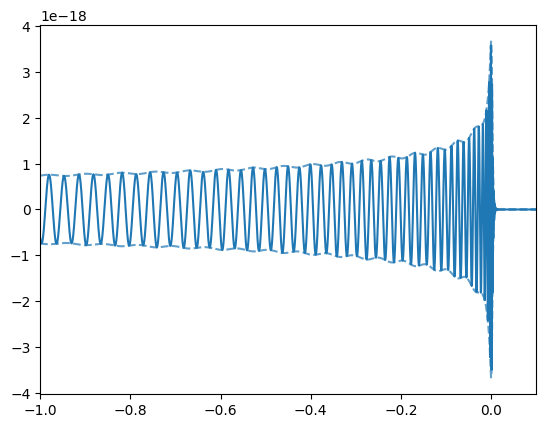

In [164]:
def teob_wf(M, q, e, chi1, chi2, f_gen, s_rate, phase=0,
            inclination=0, distance=1, f_ref_e=None,
            tlen=None, taper=True, to_fs=True,
            mode_array=[[2, 2]]):

    # Import teobresums
    try:
        import EOBRun_module
    except ImportError:
        print("Unable to import EOBRun_module, please check it is installed")
        return -1

    # Convert modes to teobresums convention
    if mode_array is None:
        mode_lm = [1]
    else:
        mode_lm = [int(x[0]*(x[0]-1)/2 + x[1]-2) for x in mode_array]

    # Convert eccentricity to correct frequency
    if f_ref_e is None:
        f_ref_e = f_gen
    else:
        e = shifted_e(f_gen, f_ref_e, e)

    # Convert Keplerian frequency to average frequency
    f_avg = f_gen*(1+e**2)/(1-e**2)**(3/2)

    # Generate waveform
    pars = {
        'M': M,
        'q': q,
        'chi1': chi1,
        'chi2': chi2,
        'LambdaAl2': 0.,
        'LambdaBl2': 0.,
        'ecc': e,
        'ecc_freq': 1,
        'domain': 0,
        'srate_interp': s_rate,
        'use_geometric_units': "no",
        'initial_frequency': f_avg,
        'interp_uniform_grid': "yes",
        'use_mode_lm': mode_lm,
        'arg_out': "yes",
        'distance': distance,
        'coalescence_angle': phase,
        'inclination': inclination
    }
    t, hp, hc, _, _ = EOBRun_module.EOBRunPy(pars)
    tmrg = t[np.argmax(np.abs(hp-1j*hc))]
    t = t - tmrg
    hp = TimeSeries(hp, t[1] - t[0], epoch=t[0])
    hc = TimeSeries(hc, t[1] - t[0], epoch=t[0])

    # Resize waveforms, taper, and return in requested domain
    if tlen is not None:
        hp.resize(tlen*s_rate)
        hc.resize(tlen*s_rate)
    if taper:
        hp = taper_timeseries(hp, tapermethod='start')
        hc = taper_timeseries(hc, tapermethod='start')
    if to_fs:
        hp = hp.to_frequencyseries()
        hc = hc.to_frequencyseries()
    return hp, hc

def compute_s_factor_test(h, s, phase_info=False):

    # Calculate peaks and s_factor
    h_peaks_inds = np.diff(np.sign(np.diff(np.abs(h)))) < 0
    s_peaks_inds = np.diff(np.sign(np.diff(np.abs(s)))) < 0
    h_peaks = h.sample_times[1:-1][h_peaks_inds]
    s_peaks = s.sample_times[1:-1][s_peaks_inds]
    s_factor = 1
    if len(h_peaks) >= 2 and len(s_peaks) >= 2:
        s_denom = (1+(h_peaks[0]-s_peaks[1])/(h_peaks[1]-h_peaks[0]))
        if s_denom != 0:
            s_factor = 1/s_denom

    if not phase_info:
        return s_factor

    # Calculate phase evolution
    h_phases = np.angle(h[h.sample_times<=h_peaks[1]])[::-1]
    h_phase_diffs = np.cumsum(np.diff(h_phases)%(2*np.pi))
    h_phases_norm = h_phases[0] + np.array([*h_phase_diffs[::-1], 0])
    s_phases = np.angle(s[s.sample_times<=s_peaks[1]])[::-1]
    s_phase_diffs = np.cumsum(np.diff(s_phases)%(2*np.pi))
    s_phases_norm = s_phases[0] + np.array([*s_phase_diffs[::-1], 0])

    # Calculate and returns phases at first two peaks
    h_phases_peaks = h_phases_norm[h_peaks_inds[:len(h_phases_norm)]][:2]
    s_phases_peaks = s_phases_norm[s_peaks_inds[:len(s_phases_norm)]][:2]

    return s_factor, h_phases_peaks, s_phases_peaks

def get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate, tlen, n_ecc_gen):

    s_f = shifted_f(f_gen, e, M, q)
    if e > 0:

        # Generate trial waveform shifted back by estimated 2pi in mean anomaly
        s_e = shifted_e(s_f, f_gen, e)
        s_wf_p, s_wf_c = teob_wf(M, q, s_e, chi1, chi2,
                         s_f, s_rate, tlen=tlen,
                         taper=False, to_fs=False)
        s_wf = s_wf_p - 1j*s_wf_c

        # Work out shift correction factor by examining peaks of both waveforms
        s_factor, h_phases_peaks, s_phases_peaks = compute_s_factor_test(
            h, s_wf, phase_info=True
        )

    else:
        s_factor = 1
    if s_factor < 0.5 or s_factor > 2:
        raise RuntimeError('Unable to accurately identify how to shift '
                           'frequency and eccentricity for component '
                           'waveforms')

    # Finds shifted frequency and eccentricity of shifted waveforms
    max_s_f = f_gen - (f_gen - s_f)*s_factor
    if max_s_f <= 0:
        raise RuntimeError('Tried to generate component waveform with '
                           'negative starting frequency')
    s_f_vals = np.linspace(f_gen, max_s_f, n_ecc_gen, endpoint=False)[1:]
    s_e_vals = shifted_e(s_f_vals, f_gen, e)

    # Calculate s_phi_factor
    s_phi_factor = compute_s_phi_factor_test(s_wf, s_f, f_gen, e, M, q, chi1, chi2)

    return s_f_vals, s_e_vals, s_phi_factor, s_factor


def gen_component_wfs_test(M, q, e, chi1, chi2, f_gen, f_low, s_rate, phase,
                          inclination, distance, tlen, n_ecc_gen, psd=None):

    # Get psd into correct format if inputted
    if psd is not None:
        if type(psd) is dict:
            psd_dict = psd
        else:
            psd_dict = {'psd': psd}
        if tlen is None:
            tlen = int(1/psd_dict[list(psd_dict.keys())[0]].delta_f)

    # Calculates first component waveform and shifts required for others
    hp, hc = teob_wf(M, q, e, chi1, chi2, f_gen, s_rate,
             phase=phase, inclination=inclination,
             distance=distance, tlen=tlen,
             taper=False, to_fs=False)
    h = hp - 1j*hc
    h_zero_phase = np.angle(h[0])
    s_f_vals, s_e_vals, s_phi_factor, s_factor = get_comp_shifts_test(h, M, q, e, chi1, chi2, f_gen, s_rate,
                                                  tlen, n_ecc_gen)

    
    print(s_factor, s_phi_factor)

    # Taper first waveform
    # h_taper_p = taper_timeseries(h.real(), tapermethod='start')
    # h_taper_c = taper_timeseries(-h.imag(), tapermethod='start')
    # h = h_taper_p - 1j*h_taper_c

    # Calculates psd if not inputted
    if psd is None:
        h.resize(2**np.ceil(np.log2(len(h))))
        delta_f = 1.0 / h.duration
        flen = len(h)//2 + 1
        psd_dict = {'psd': aLIGOZeroDetHighPower(flen, delta_f, f_low)}

    # Save first component waveform
    h_ts = h.sample_times
    h_dt = h.delta_t
    comp_starts = [h.sample_times[0]]
    comp_wfs = {key: [h] for key in psd_dict.keys()}

    # Generate all component waveforms
    for i in range(n_ecc_gen-1):

        # Create waveform
        hp, hc = teob_wf(M, q, s_e_vals[i], chi1, chi2,
                         s_f_vals[i], s_rate, phase=phase,
                         inclination=inclination,
                         distance=distance, tlen=tlen,
                         to_fs=False, taper=False)
        h = hp - 1j*hc
        h *= np.exp(1j*(h_zero_phase-np.angle(h[0])))
        comp_starts.append(h.sample_times[0])

        # Trim waveform to same size as first (shortest)
        wf_trim_interpolate = interp1d(h.sample_times, h, bounds_error=False,
                                       fill_value=0)
        wf_trim_strain = wf_trim_interpolate(h_ts)
        h = TimeSeries(wf_trim_strain, h_dt,
                       epoch=comp_starts[0])

        # Correct phase and taper for each psd
        for key in psd_dict.keys():

            # Evolution phase shift method
            delta_phi = calc_delta_phi([comp_starts[0], comp_starts[i+1]],
                                       [f_gen, s_f_vals[i]],
                                       f_gen, e, M , q, chi1, chi2)
            h_psd = h*np.exp(1j*delta_phi*s_phi_factor)

            # h_psd = h*np.exp(1j*s_phi_vals[i])

            # # Re-taper waveform after trimming
            # h_taper_p = taper_timeseries(h_psd.real(), tapermethod='start')
            # h_taper_c = taper_timeseries(-h_psd.imag(), tapermethod='start')
            # h_psd = h_taper_p - 1j*h_taper_c

            comp_wfs[key].append(h_psd)

    return comp_wfs, psd_dict

comp_wfs =  gen_component_wfs_test(30, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                   0, 1, 32, 12, psd=None)[0]['psd']
h0 = comp_wfs[0].copy()
for i in range(1, len(comp_wfs)):
    h0 += comp_wfs[i]
plt.plot(h0.sample_times, h0, c='C0')
plt.plot(h0.sample_times, np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.plot(h0.sample_times, -np.abs(h0), c='C0', alpha=0.7, ls='dashed')
plt.xlim(-1, 0.1)
plt.show()

In [105]:
## TESTING - ONLY WORKS IF DISABLING PHASE CORRECTION, TRIMMING, AND TAPERING ABOVE
first_wf = comp_wfs[0]
test_wf = comp_wfs[4]

first_phis = np.angle(first_wf)
phi_interp = interp1d(first_wf.sample_times, first_phis, kind='linear', fill_value='extrapolate')


ft_interp = interp1d([first_wf.sample_times[0], test_wf.sample_times[0]],
                     [10, 9.74787623], kind='linear')
ts = np.linspace(first_wf.sample_times[0], test_wf.sample_times[0], 10**5)
P_0 = 2/10
cum_P = integrate.cumulative_trapezoid(dP_dt(ft_interp(ts), 0.4, 60, 2, 0, 0), ts, initial=0)
delta_phi = -4*np.pi*integrate.trapezoid(1/(cum_P+P_0), ts)


print(delta_phi)

-0.0


# Test SVDs

In [165]:
# Generate wf components
comp_wfs_svd_full =  gen_component_wfs_test(30, 2, 0.4, 0, 0, 10, 10, 4096, 0,
                                            0, 1, 32, 50, psd=None)[0]['psd']

# Get inspiral sections
t_upper_ind = np.argmin(np.abs(comp_wfs_svd_full[0].sample_times+0.1))
t_lower_ind = np.max([int(4096*0.1), t_upper_ind-int(4096*8)])
comp_wfs_svd_short = [wf[t_lower_ind:t_upper_ind] for wf in comp_wfs_svd_full]

# Perform SVD
print('Starting SVD calculation')
start = time.time()
X = np.array(comp_wfs_svd_short)
means = X.mean(axis=1)
stds = X.std(axis=1)
Uh, S, V = np.linalg.svd(((X.T-means)/stds).T)
end = time.time()
print(f'Time taken: {end-start} seconds')

# Make full length harmonics
inv_S = 1/S
U = np.conj(Uh).T
inv_S_U = np.matmul(np.diag(inv_S), U)
SVD_harms_full = np.matmul(inv_S_U, np.array(comp_wfs_svd_full))

1.006928403489909 1.0310765345525041
Starting SVD calculation
Time taken: 64.13839077949524 seconds


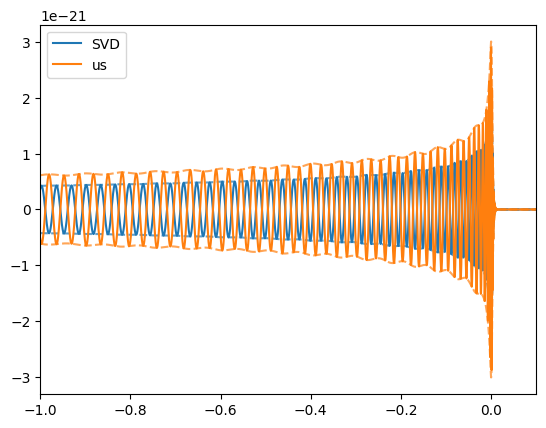

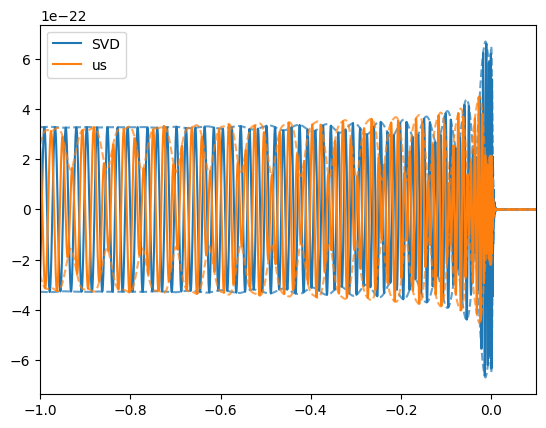

In [ ]:
# Plot harmonic comparison
harm_inds = [0,1,-1]
for i in range(len(harm_inds)):
    plt.plot(comp_wfs_svd_full[0].sample_times, SVD_harms_full[i], c='C0', label='SVD')
    plt.plot(comp_wfs_svd_full[0].sample_times, np.abs(SVD_harms_full[i]), c='C0', alpha=0.7, ls='dashed')
    plt.plot(comp_wfs_svd_full[0].sample_times, -np.abs(SVD_harms_full[i]), c='C0', alpha=0.7, ls='dashed')
    harm = comp_wfs_svd_full[0].copy()
    for j in range(1, len(comp_wfs_svd_full)):
        harm += np.exp(1j*harm_inds[i]*j/(2*np.pi))*comp_wfs_svd_full[j]
    plt.plot(harm.sample_times, harm*0.0002, c='C1', label='us')
    plt.plot(harm.sample_times, np.abs(harm)*0.0002, c='C1', alpha=0.7, ls='dashed')
    plt.plot(harm.sample_times, -np.abs(harm)*0.0002, c='C1', alpha=0.7, ls='dashed')
    plt.legend()
    plt.xlim(-1, 0.1)
    plt.show()

In [ ]:
# Make coefficient plot
n_comp = 6
lim = 0.5
f = plt.figure(figsize=(6.4*0.75*n_comp/2, 3.75*0.75))
widths = np.ones(n_comp)
widths[-1] += 0.25
f.subplots(1, n_comp, gridspec_kw={'width_ratios': widths, 'wspace': 0}, sharey=True)
colors = np.linspace(0, 2*np.pi, len(comp_wfs_svd_short), endpoint=False)
U = np.conj(Uh).T
for i in range(n_comp):
    plt.subplot(1, n_comp, i+1)
    plt.scatter(np.real(U[i]), np.imag(U[i]), c=colors, vmin=0, vmax=2*np.pi, cmap='twilight_shifted')
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.xlabel(r'Re($U_%d$)' % i)
    if i == 0:
        plt.ylabel('Im($U_k$)')
    else:
        plt.gca().get_yaxis().set_visible(False)

# Plot formatting
plt.colorbar(label='Mean anomaly')
plt.tight_layout()
plt.show()

In [ ]:
coeffs = [0,1,-1,2,3,4]
for i in range(len(coeffs)):
    raw_angles = np.angle(U[i])%(2*np.pi)
    exp_angles = np.angle(np.exp(coeffs[i]*1j*2*np.pi/len(raw_angles))**np.arange(len(raw_angles)))
    diff_angles = (raw_angles - exp_angles)%(2*np.pi)
    mean_angle = np.angle(np.sum(np.exp(1j*diff_angles)))%(2*np.pi)
    diff_norm_angles = (diff_angles - mean_angle)
    diff_norm_angles = (diff_norm_angles+np.pi)%(2*np.pi)-np.pi
    plt.plot(np.arange(len(raw_angles)), diff_norm_angles)
    plt.xlabel('comp wf no')
    plt.ylabel('deviation from expected angle')
    plt.show()

# Testing scraps

In [112]:
hp, hc = teob_wf(60, 2, 0.4, 0, 0, 10, 4096,
                 phase=0, inclination=0,
                 distance=1000, tlen=32,
                 taper=False, to_fs=False)
h = hp-1j*hc
h_peaks_inds = np.diff(np.sign(np.diff(np.abs(h)))) < 0
h_peaks = h.sample_times[1:-1][h_peaks_inds]

h_phases = np.angle(h[h.sample_times<=h_peaks[2]])[::-1]
h_phase_diffs = np.cumsum(np.diff(h_phases)%(2*np.pi))
h_phases_norm = h_phases[0] + np.array([*h_phase_diffs[::-1], 0])

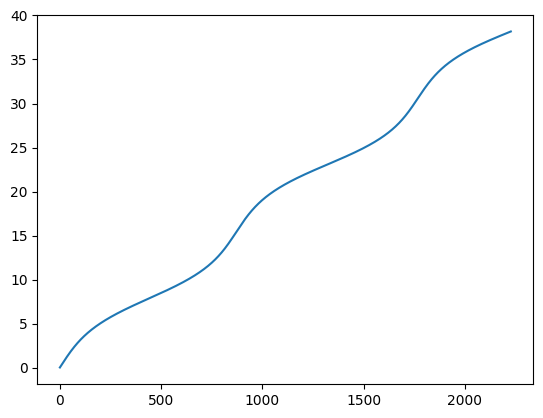

In [113]:
plt.plot(np.arange(len(h_phase_diffs)), h_phase_diffs)
plt.show()

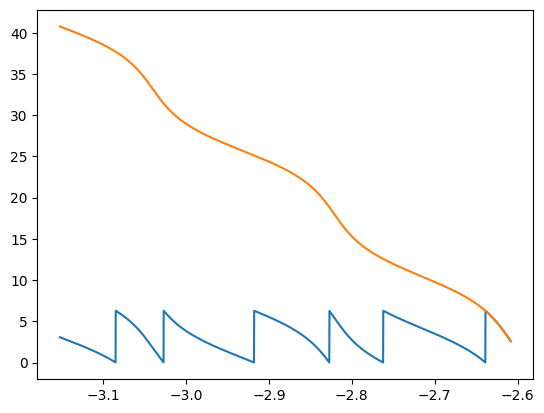

In [114]:
plt.plot(h.sample_times[:len(h_phases_norm)], np.angle(h[:len(h_phases_norm)])%(2*np.pi))
plt.plot(h.sample_times[:len(h_phases_norm)], h_phases_norm)
plt.show()

In [141]:
s_phi_vals = [0, 1.25932869, 2.51816075, 3.77649617, 5.03433496, 6.29167711, 7.54852263,
              8.80487151, 10.06072376, 11.31607938, 12.57093836, 13.82530071]
s_phi_unif = np.linspace(0, s_phi_vals[-1], len(s_phi_vals))
print(s_phi_vals - s_phi_unif)

[0.         0.00248317 0.00446971 0.00595961 0.00695288 0.00744951
 0.00744952 0.00695288 0.00595961 0.00446971 0.00248317 0.        ]


In [187]:
comp_wfs

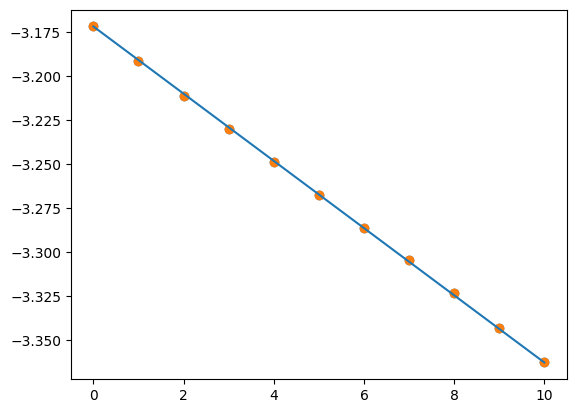

In [190]:
comp_starts = [-3.171630859, -3.191162109, -3.2109375, -3.229980469, -3.248779297, -3.267333984, -3.285888672, -3.304443359, -3.323242188, -3.342773438, -3.362548828]
plt.scatter(np.arange(len(comp_starts)), comp_starts)
plt.plot([0, len(comp_starts)-1], [comp_starts[0], comp_starts[-1]])
plt.show()

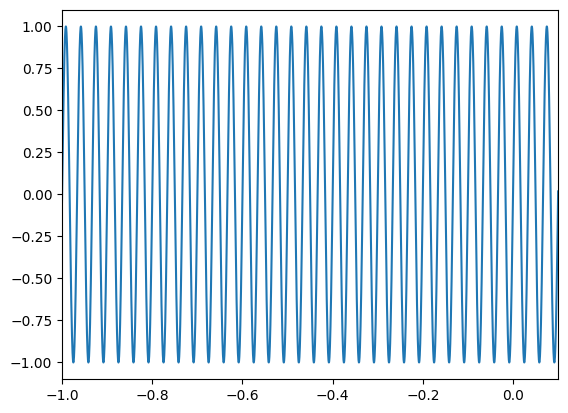

In [214]:
plt.plot(test_sin.sample_times, test_sin)
plt.xlim(-1, 0.1)
plt.show()

In [234]:
test_sin = np.sin(2*np.pi*30*comp_wfs[0].sample_times[100:])
test_sin = TimeSeries(test_sin, comp_wfs[0].delta_t,
                      epoch=comp_wfs[0].start_time)
for i in range(len(comp_wfs)):
    test_wf = comp_wfs[i][comp_wfs[i].sample_times <= 0][100:]
    test_wf = TimeSeries(test_wf, comp_wfs[i].delta_t,
                          epoch=comp_wfs[i].start_time)
    ovlp = overlap_cplx(test_wf.real()/np.abs(test_wf), test_sin[:len(test_wf)], low_frequency_cutoff=20, normalized=True)
    print(np.angle(ovlp)%(2*np.pi))

0.8604062710977436
0.41878094676550853
0.08296725363643763
6.079918047674812
0.4361328893137995
0.2275103602766601
5.920378881786814
5.448141348832375
0.13792083765022806
5.579166736211629
2.898400719224141
1.6119355361520773


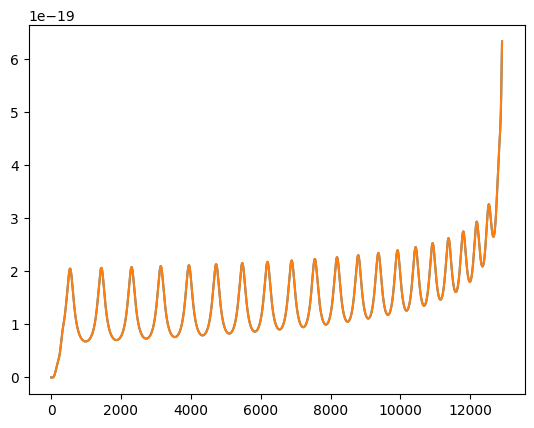

In [232]:
plt.plot(np.abs(test_wf))
plt.show()

In [206]:
test_sin